<a href="https://colab.research.google.com/github/lhodzic1/Movie-Reviews-Sentiment-Analysis/blob/main/NLP_project_Bert_IMDB_without_overlap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!%%cache
!pip install rpy2

/bin/bash: line 0: fg: no job control
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!%%cache
from google.colab import drive

drive.mount('/content/drive')

/bin/bash: line 0: fg: no job control
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**Data loading**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

x_train = pd.read_csv('drive/MyDrive/NLP/data/x_train_without_overlap.csv') #when not in colab use 'data/x_train_without_overlap.csv'
y_train = pd.read_csv('drive/MyDrive/NLP/data/y_train_without_overlap.csv') #'data/y_train_without_overlap.csv'
#x_test = pd.read_csv('drive/MyDrive/NLP/data/x_test_without_overlap.csv')
#y_test = pd.read_csv('drive/MyDrive/NLP/data/y_test_without_overlap.csv')

df_train = pd.concat([x_train, y_train], axis=1, join='inner')
#df_test = pd.concat([x_test, y_test], axis=1, join = 'inner')


#df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

#saving validation and test split
#df_test.to_csv('drive/MyDrive/NLP/data/NLP_test_case_validation_without_overlap.csv', index = False, encoding='utf-8')
#df_val.to_csv('drive/MyDrive/NLP/data/NLP_validation_without_overlap.csv', index = False, encoding='utf-8')

df_test = pd.read_csv('drive/MyDrive/NLP/data/NLP_test_case_validation_without_overlap.csv')
df_val = pd.read_csv('drive/MyDrive/NLP/data/NLP_validation_without_overlap.csv')

In [ ]:
df_train.review

0        heres interesting ltle  strictly gives phrase ...
1        loc  kargil war fought locations budget skill ...
2        cant believe  allowed made  drug beat blunt ob...
3        look new cars expect shown boats drink fountai...
4        remade today  creepy disturbing dark comedy st...
                               ...                        
42495     dvd producers forgotten ttles importance goer...
42496    ok all  sucks lets examine why proposion machi...
42497    review contains spoiler  american ninja myster...
42498    team merian cooper ernest schoedsack produced ...
42499    robert taylor mad buffalo hunter charlie gilso...
Name: review, Length: 42500, dtype: object

##**BERT**

In [ ]:
!%%cache
!pip install -q -U watermark

/bin/bash: line 0: fg: no job control


In [ ]:
!%%cache
!pip install -qq transformers

/bin/bash: line 0: fg: no job control
     |████████████████████████████████| 4.4 MB 32.0 MB/s 
     |████████████████████████████████| 596 kB 69.2 MB/s 
     |████████████████████████████████| 6.6 MB 55.0 MB/s 
     |████████████████████████████████| 101 kB 13.6 MB/s 


In [ ]:
!%%cache
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

/bin/bash: line 0: fg: no job control
Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

numpy       : 1.21.6
pandas      : 1.3.5
torch       : 1.12.0+cu113
transformers: 4.20.1



In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Trying tokenizer and encoding

In [ ]:
sample_txt = 'Introduction to Natural Language Processing '

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

Finding max length

In [ ]:
'''
token_lens = []

for txt in df_train.review:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

element_count = len([item for item in token_lens if item > 256])
element_count
'''

'\ntoken_lens = []\n\nfor txt in df_train.review:\n  tokens = tokenizer.encode(txt, max_length=512)\n  token_lens.append(len(tokens))\n\nelement_count = len([item for item in token_lens if item > 256])\nelement_count\n'

In [ ]:
'''
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');
'''

"\nsns.distplot(token_lens)\nplt.xlim([0, 512]);\nplt.xlabel('Token count');\n"

In [ ]:
MAX_LEN = 512

**Data preprocessing**

In [ ]:
class MovieReviewsDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((42500, 2), (3750, 2), (3750, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MovieReviewsDataset(
    reviews=df.review.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

dict_keys(['review', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 512])
torch.Size([32, 512])
torch.Size([32])


**Classifier**

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #PRE_TRAINED_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

In [ ]:
o = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [ ]:
class MovieReviewsClassifier(nn.Module):

  def __init__(self, n_classes):
    super(MovieReviewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    ob = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(ob.pooler_output)
    return self.out(output)

In [ ]:
class_names = ['positive', 'negative'] 

In [ ]:
model = MovieReviewsClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 512])
torch.Size([32, 512])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4963, 0.5037],
        [0.5091, 0.4909],
        [0.5275, 0.4725],
        [0.5024, 0.4976],
        [0.5442, 0.4558],
        [0.4962, 0.5038],
        [0.5069, 0.4931],
        [0.5063, 0.4937],
        [0.5013, 0.4987],
        [0.5191, 0.4809],
        [0.5311, 0.4689],
        [0.5017, 0.4983],
        [0.5209, 0.4791],
        [0.5106, 0.4894],
        [0.5026, 0.4974],
        [0.5101, 0.4899],
        [0.5018, 0.4982],
        [0.5080, 0.4920],
        [0.4937, 0.5063],
        [0.5062, 0.4938],
        [0.5134, 0.4866],
        [0.5038, 0.4962],
        [0.5186, 0.4814],
        [0.4996, 0.5004],
        [0.5043, 0.4957],
        [0.5053, 0.4947],
        [0.5181, 0.4819],
        [0.5100, 0.4900],
        [0.5274, 0.4726],
        [0.5229, 0.4771],
        [0.5119, 0.4881],
        [0.5261, 0.4739]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

**Training**

In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

Train loss 0.30454473184566017 accuracy 0.870964705882353


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.2491856636953051 accuracy 0.8957333333333334

Epoch 2/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.20881722898322716 accuracy 0.918329411764706


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.24410199806473012 accuracy 0.9064000000000001

Epoch 3/3
----------


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.17477979764490872 accuracy 0.9351529411764706


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.25298902640213905 accuracy 0.9029333333333334

CPU times: user 41min 3s, sys: 6.98 s, total: 41min 10s
Wall time: 42min 48s


In [ ]:
history_train_acc = torch.Tensor.cpu(torch.tensor(history['train_acc']))
history_val_acc = torch.Tensor.cpu(torch.tensor(history['val_acc']))

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

0.9109333333333334

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  sar_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      sar_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sar_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.91      0.91      0.91      1863
    negative       0.91      0.91      0.91      1887

    accuracy                           0.91      3750
   macro avg       0.91      0.91      0.91      3750
weighted avg       0.91      0.91      0.91      3750



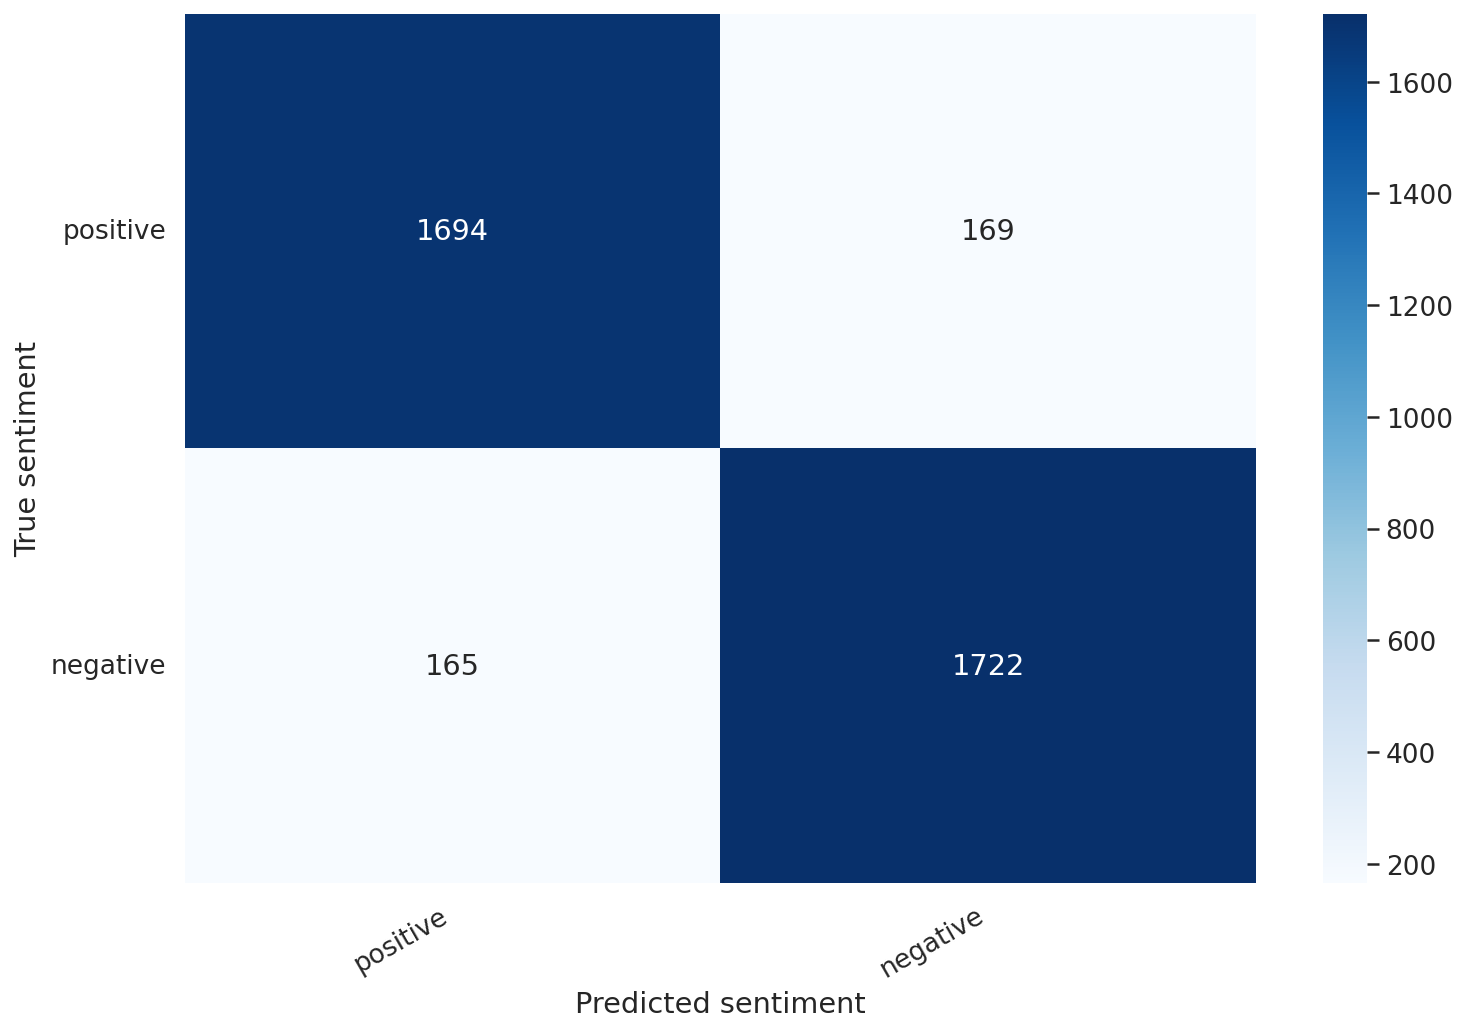

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## **Saving predictions and the model**

In [ ]:
from os import path

def json_metrics(file_name, prediction_model, metrics, df):
    dictionary = {'Model': prediction_model,
                  'Metrics': metrics,
                  'Data': df.to_dict('records')}

    if path.isfile(file_name): #file exist
        with open(file_name) as fp:
            listObj = json.load(fp)

        listObj.append(dictionary)

        with open(file_name, 'w') as json_file:
            json.dump(listObj, json_file, indent=4)
    else:
        with open(file_name, 'w') as json_file:
            json.dump([dictionary], json_file, indent=4)

In [ ]:
from sklearn import metrics as m
import json
def metrics(y_test, y_pred, target_names):
    tn, fp, fn, tp = m.confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
    dict_confusion = {'True negative' : int(tn),
          'False positive' : int(fp),
          'False negative' : int(fn),
          'True positive' : int(tp),
          }
    dict_report = m.classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    return {**dict_confusion , **dict_report}

In [ ]:
metrics = metrics(y_test, y_pred, ['1','0'])

In [ ]:
y_test_ids = np.arange(y_test.shape[0])

In [ ]:
#dataframe
df= pd.DataFrame({'id': y_test_ids, 'label': y_test, 'prediction': y_pred})

**remove # when writing new results**

In [ ]:
json_metrics("drive/MyDrive/NLP/NLP_Bert_IMDB_without_overlap.json", "sentence-transformers/all-MiniLM-L6-v2 - IMDB without overlap", metrics, df )

In [ ]:
!ls

best_model_state.bin  drive  sample_data


**remove # when saving new model**

In [ ]:

torch.save(model, 'drive/MyDrive/NLP/NLP_Bert_Model_IMDB_without_overlap')

## **Neutral Dataset**

In [ ]:
import pandas as pd

saved_model = torch.load('drive/MyDrive/NLP/NLP_Bert_Model_IMDB_without_overlap')

df_neutral = pd.read_csv('drive/MyDrive/NLP/data/neutral_without_overlap.csv')
df_neutral.rename(columns = {'Phrase':'review', 'Sentiment':'sentiment'}, inplace = True)
test_data_loader = create_data_loader(df_neutral, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  saved_model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/py

In [ ]:
y_test_ids_neutral = df_neutral['SentenceId'].to_numpy()

In [ ]:
y_pred_prob_list = y_pred_probs.tolist()
y_test_list = y_test.tolist()
y_pred_list = y_pred.tolist()
y_test_ids_neutral_list = y_test_ids_neutral.tolist()

list_of_all = list(zip(y_test_ids_neutral_list, y_test_list, y_pred_list, y_pred_prob_list))

df_prob = pd.DataFrame(list_of_all,
                  columns=['Id', 'Label', 'Prediction', 'Probability'])

df_prob.head()

,Id,Label,Prediction,Probability
0,1,1,1,"[0.08843383193016052, 0.9115661382675171]"
1,2,4,1,"[0.01961187645792961, 0.9803881645202637]"
2,3,1,1,"[0.25709962844848633, 0.7429003715515137]"
3,4,3,1,"[0.005898020230233669, 0.9941019415855408]"
4,5,1,0,"[0.540503740310669, 0.45949631929397583]"


In [ ]:
df_prob.to_csv('drive/MyDrive/NLP/df_prob_neutral_without_overlap.csv', index = False, encoding='utf-8')

In [ ]:
def metrics_for_neutral(y_test, y_pred, target_names):
  FP = TP = TN = FN = NP = NN = 0

  for i in range(len(y_pred)):
    prediction = y_pred.numpy()[i]
    true = y_test.numpy()[i]

    if prediction == 1 and (true == 1 or true == 0):
      FP += 1
    elif prediction == 1 and (true == 3 or true == 4):
      TP += 1
    elif prediction == 0 and (true == 1 or true == 0) :
      TN += 1
    elif prediction == 0 and (true == 3 or true == 4):
      FN += 1
    elif prediction == 1 and true == 2:
      NP += 1
    elif prediction == 0 and true == 2:
      NN += 1
      
  dict_confusion = {'True negative' : int(TN),
        'False positive' : int(FP),
        'False negative' : int(FN),
        'True positive' : int(TP),
        'Neutral positive' : int(NP),
        'Neutral negative' : int(NN),
        }
  return {**dict_confusion}

In [ ]:
metrics_for_neutral = metrics_for_neutral(y_test, y_pred, ['1','0'])

In [ ]:
metrics_for_neutral

{'False negative': 523,
 'False positive': 1119,
 'Neutral negative': 619,
 'Neutral positive': 1036,
 'True negative': 2153,
 'True positive': 3079}

In [ ]:
y_test_ids_neutral = df_neutral['SentenceId'].to_numpy()

In [ ]:
df_neutral_json= pd.DataFrame({'id': y_test_ids_neutral, 'label': y_test, 'prediction': y_pred})

In [ ]:
import json
json_metrics("drive/MyDrive/NLP/NLP_Bert_Neutral_without_overlap.json", "sentence-transformers/all-MiniLM-L6-v2 - Neutral_without_overlap", metrics_for_neutral, df_neutral_json )